In [1]:
from PIL import Image
import requests
import os, glob
import pandas as pd
import numpy as np
import re
from transformers import CLIPProcessor, CLIPModel
import importlib
import torch
# Make changes to esd_diffusers.py file here
from eta_diffusion import FineTunedModel, StableDiffuser
import matplotlib.pyplot as plt

/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from clip_utils import erased_gen, get_clip_scores, get_simple_clip_scores, show_image_grid_with_scores
from clip_utils import interference_gen

In [3]:
pretrained_model_name_or_path = "hf-internal-testing/tiny-stable-diffusion-pipe"


In [4]:
import pandas as pd
import torch
import numpy as np
from diffusers import StableDiffusionPipeline, DDIMScheduler

CAR_XATTN_MODEL=""
CAR_GA_MODEL="/share/u/kevin/ErasingDiffusionModels/Gradient_ascent_traininig_scripts/checkpoint/car"
CAR_NOXATTN_MODEL="/share/u/kevin/ErasingDiffusionModels/ESD_training_scripts/models/esd-car_from_car-noxattn_1-epochs_200.pt"

DOG_MODEL="/share/u/kevin/ErasingDiffusionModels/Gradient_ascent_traininig_scripts/checkpoint/english_springer"

pipeline = StableDiffusionPipeline.from_pretrained(DOG_MODEL)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.safety_checker = None  # Disable the NSFW checker
pipeline = pipeline.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.98it/s]


In [5]:
from diffusers import UNet2DConditionModel

unet_path = '/share/u/kevin/ErasingDiffusionModels/Gradient_ascent_traininig_scripts/task_vectors/english_springer_5000/unet'
unet = UNet2DConditionModel.from_pretrained(unet_path, use_safetensors=False)


In [6]:
pipeline.unet = unet
pipeline = pipeline.to("cuda")

In [7]:

def interrupt_callback(pipeline, i, t, callback_kwargs):
    stop_idx = 45
    if i == stop_idx:
        pipeline._interrupt = True

    return callback_kwargs

car_images = pipeline("english springer spaniel", num_inference_steps=50, generator=torch.manual_seed(2440), eta=0.0, callback_on_step_end=interrupt_callback).images


  0%|          | 0/50 [00:00<?, ?it/s]/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 92%|█████████▏| 46/50 [00:05<00:00,  8.82it/s]


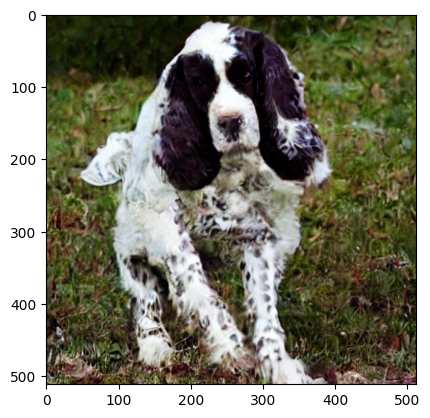

In [22]:
plt.imshow(car_images[0])

In [4]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")
pipeline.enable_model_cpu_offload()
num_inference_steps = 50

def interrupt_callback(pipeline, i, t, callback_kwargs):
    stop_idx = 10
    if i == stop_idx:
        pipeline._interrupt = True

    return callback_kwargs

pipeline(
    "A photo of a cat",
    num_inference_steps=num_inference_steps,
    callback_on_step_end=interrupt_callback,
)


  0%|          | 0/50 [00:00<?, ?it/s]/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 20%|██        | 10/50 [00:31<02:07,  3.19s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FC8986278E0>], nsfw_content_detected=[True])

In [4]:
car_images = pipeline("english springer", num_inference_steps=50, generator=torch.manual_seed(2440), eta=0.0).images


  0%|          | 0/50 [00:00<?, ?it/s]

/share/u/kevin/miniconda3/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


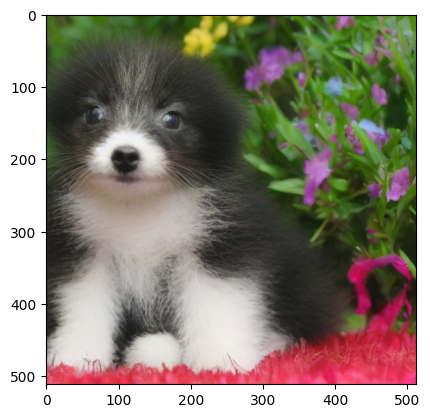

In [5]:
plt.imshow(car_images[0])

In [ ]:
class ExperimentImageSet:
    def __init__(self, stable_diffusion, eta_0_image, attack_images, interference_images = None, prompt: str = None, interference_prompt1 = None, interference_prompt2 = None, seed: int = None):
        self.stable_diffusion: np.ndarray = stable_diffusion
        self.eta_0_image: np.ndarray = eta_0_image
        self.attack_images: np.ndarray = attack_images
        self.interference_images: np.ndarray = interference_images
        self.target_prompt = prompt
        self.seed = seed
        self.interference_prompt1 = interference_prompt1
        self.interference_prompt2 = interference_prompt2

def pipeline_erased_gen(target_csv_path, target_prompt, target_model_path, etas, num_prompts):
    # Load the target and interference CSV files
    target_data = pd.read_csv(target_csv_path)

    torch.cuda.empty_cache()
    variance_scales = [1.0]  # Adjust variance scales as needed

    # Placeholder for the total images and experiment sets
    total_images = []
    total_experiment_sets = []
    ct = 0
    original_pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
    original_pipeline.scheduler = DDIMScheduler.from_config(original_pipeline.scheduler.config)
    original_pipeline.safety_checker = None  # Disable the NSFW checker
    original_pipeline = original_pipeline.to("cuda")
    pipeline = StableDiffusionPipeline.from_pretrained(target_model_path)
    pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
    pipeline.safety_checker = None  # Disable the NSFW checker
    pipeline = pipeline.to("cuda")

    # Iterate through the target data along with interference data from the other two CSVs
    for index, row in target_data.head(num_prompts).iterrows():

        prompt = row['prompt']
        seed = int(row['evaluation_seed'])
        
        # Base stable diffusion image
        generator = torch.manual_seed(seed)

        
        stable_diffusion = original_pipeline(prompt, num_inference_steps=50, generator=generator, eta=0.0).images[0]
        stable_diffusion = np.array(stable_diffusion)  # Convert to np.ndarray
        total_images.append(stable_diffusion)

        # No attack image (eta=0, variance_scale=0)
        finetuned_no_attack = pipeline(prompt, num_inference_steps=50, generator=generator, eta=0.0).images[0]
        finetuned_no_attack = np.array(finetuned_no_attack)  # Convert to np.ndarray
        total_images.append(finetuned_no_attack)

        # Attack images with varying eta and variance scales
        attack_images = []
        for eta in etas:
            for variance_scale in variance_scales:
                attacked_image = pipeline(
                    prompt,
                    num_inference_steps=50,
                    generator=generator,
                    eta=eta,
                    variance_scale=variance_scale  # Assuming variance_scale is supported directly
                ).images[0]
                attacked_image = np.array(attacked_image)  # Convert to np.ndarray
                attack_images.append(attacked_image)
        attack_images = np.array(attack_images)  # Convert list to np.ndarray
        total_images.extend(attack_images)

        # Construct an experiment set with the images, including the interference images
        experiment_set = ExperimentImageSet(
            stable_diffusion=stable_diffusion,
            eta_0_image=finetuned_no_attack,
            attack_images=attack_images,
            interference_images=None, 
            prompt=target_prompt,
            seed=seed,
            interference_prompt1=None,
            interference_prompt2=None
        )
        total_experiment_sets.append(experiment_set)

        ct += 1 + len(etas) * len(variance_scales)
        print(f"diffusion-count {ct} for prompt: {prompt}")

    # Convert total images to a NumPy array
    total_images = np.array(total_images)

    # Assuming fixed_images is needed as an array of final images
    fixed_images = [image for image in total_images]
    fixed_images = np.array(fixed_images)

    print("Image grid shape:", fixed_images.shape)

    return fixed_images, total_experiment_sets
